# Dataset for Classification

In this notebook we explore the dataset for training, validating and testing the classification model.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [1]:
import os
import yaml
import argparse

from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Save program's directory
cwd = os.getcwd()
if cwd == '/content':  # If we are in colab, we mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change dir to where project is located
    os.chdir("drive/MyDrive/CoVision/classification")
    cwd = os.getcwd()
elif 'drive' in cwd:  # Already monted and changed dir
    pass
elif 'notebooks' in os.listdir(cwd):  # Local machine case
    cwd = './'
else:  # If currently in notebook folder
    os.chdir('./..')
    cwd = './'
print(f'Current working directory: {cwd}\n')

# Read arguments from dict and store them as Namespace
with open(cwd + 'config.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)

# Update directories for colab
config_dict['data_args']['data_dir'] = os.path.join(cwd, config_dict['data_args']['data_dir'])
config_dict['training_args']['save_path'] = os.path.join(cwd, config_dict['training_args']['save_path'])

args = argparse.Namespace(**config_dict)
data_args = argparse.Namespace(**config_dict['data_args'])
training_args = argparse.Namespace(**config_dict['training_args'])

print(data_args, '\n')
print(training_args, '\n')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


Current working directory: ./

Namespace(crop_locs=[0.1, 0.5, 0.9], data_dir='./data/', membrane_shape=[160, 480], sequences=['11', '10', '01', '00'], train_test_split=0.8, train_val_split=0.8, zone_shape=[160, 160]) 

Namespace(batch_size=16, epochs=10, lr=0.001, num_workers=0, save_path='./models/', scheduler_gamma=0.2, scheduler_step=30, seed=42, weight_decay=1e-05) 



## Raw data

For each kit, we have a separate folder named `{kit_id}`, e.g. `aconag`, and the raw data sits inside the `{kit_id}_membranes` sub-folder. It contains images (.jpg) of kit membranes.

Number of images: 324
First image path: ./data/aconag/aconag_membranes/IMG_0254.jpg
Types: <class 'numpy.ndarray'>, uint8
Shape: (566, 117, 3)
Max-Min values: (239, 57)


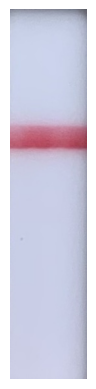

In [2]:
kit_id = 'aconag'
membranes_folder = os.path.join(data_args.data_dir, kit_id, f'{kit_id}_membranes')

image_paths = sorted([os.path.join(membranes_folder, img) for img in os.listdir(membranes_folder)])

print(f'Number of images: {len(image_paths)}')
print(f'First image path: {image_paths[0]}')

# Read image
image_raw = cv2.imread(image_paths[0])
print(f'Types: {type(image_raw)}, {image_raw.dtype}')
print(f'Shape: {image_raw.shape}')
print(f'Max-Min values: ({image_raw.max()}, {image_raw.min()})')

# Display
plt.imshow(image_raw[:,:,::-1])
plt.axis('off')
plt.show()

The labels are stored in the file `{kit_id}_labels.csv` and consist on the line-sequence for each membrane image. Such sequences are stored in the line_sequence column as strings of the form "10", "11", etc. corresponding to 1 for red line (positive), 0 for no line (negative). The file also contains the `data_mode` to which the example is assigned, namely train, val or test.  

In [3]:
labels_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_labels.csv'), index_col=0, dtype=str)
print(labels_df['line_sequence'].dtype)
labels_df.head(10)

object


,line_sequence,data_mode
IMG_0254,10,train
IMG_0255,11,train
IMG_0256,11,train
IMG_0257,10,train
IMG_0258,11,test
IMG_0259,10,val
IMG_0260,10,train
IMG_0261,10,train
IMG_0262,10,train
IMG_0263,10,train


## Data split

The raw data must be split into train, validation, and test sets. In order to do so we use the custom function `split_data`.

In [4]:
from src.data.preprocessing import split_data
from src.utils.visualization import show_dataset

In [5]:
kit_id='paramountag'
split_data(data_args, kit_id)

File ./data/paramountag/paramountag_labels.csv already has a train/val/test split! Do you want to overwrite it? (y/n): n


SystemExit: The file was not overwritten :)

/home/guybrush/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


If the split was carried on correctly, there should be an equal distribution of line-sequence configurations for train, val, and test sets.

train {'11': 70, '10': 57, '01': 0, '00': 2}
test {'11': 22, '10': 18, '01': 0, '00': 1}
val {'11': 18, '10': 15, '01': 0, '00': 1}


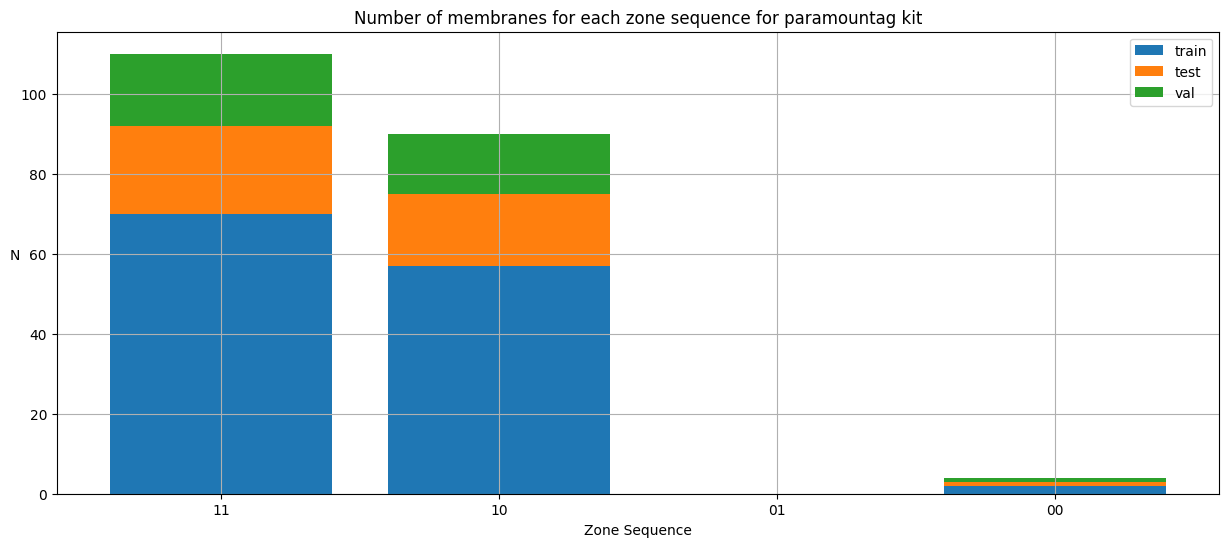

In [6]:
show_dataset(data_args, kit_id=kit_id)

## Cropped zones checker

Since we use universal cropping locations to crop the zones of membranes, we need to check whether all images in the dataset are separated correctly. To this end, we have the `check_cropped_zones` function.

In [7]:
from src.data.preprocessing import check_cropped_zones

In [8]:
kit_id='aconag'
# cropped_zones_checker(data_args, kit_id)

## Dataset and Dataloader

We can use the `MembraneZonesDataset` class to create our custom Pytorch's dataset.

In [12]:
from src.data.dataset import MembraneZonesDataset
from src.data.dataloader import init_dataloader
from src.utils.visualization import show_zones

In [10]:
kit_id = 'aconag'
dataset_train = MembraneZonesDataset(data_args, kit_id=kit_id, data_mode='train', shots=None, transform=None)
dataset_test = MembraneZonesDataset(data_args, kit_id=kit_id, data_mode='test', shots=None, transform=None)
dataset_val = MembraneZonesDataset(data_args, kit_id=kit_id, data_mode='val', shots=None, transform=None)

There are 205 membranes (410 zones) in the aconag kit for train data mode
There are 66 membranes (132 zones) in the aconag kit for test data mode
There are 53 membranes (106 zones) in the aconag kit for val data mode


tensor([1., 1.]) torch.Size([2])
torch.Size([2, 3, 160, 160])


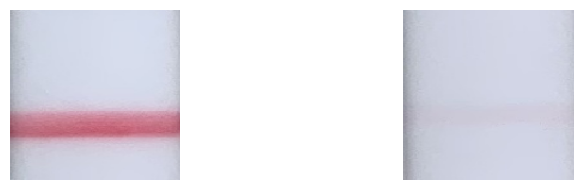

In [11]:
idx=9
zones, labels = dataset_train[idx]
print(labels, labels.shape)
print(zones.shape)
show_zones(zones)

In [17]:
loader_train = init_dataloader(data_args, kit_id, 'train', n_workers=0, n_batches=4, shuffle=True)

There are 205 membranes (410 zones) in the aconag kit for train data mode


torch.Size([8, 1])
torch.Size([8, 3, 160, 160])


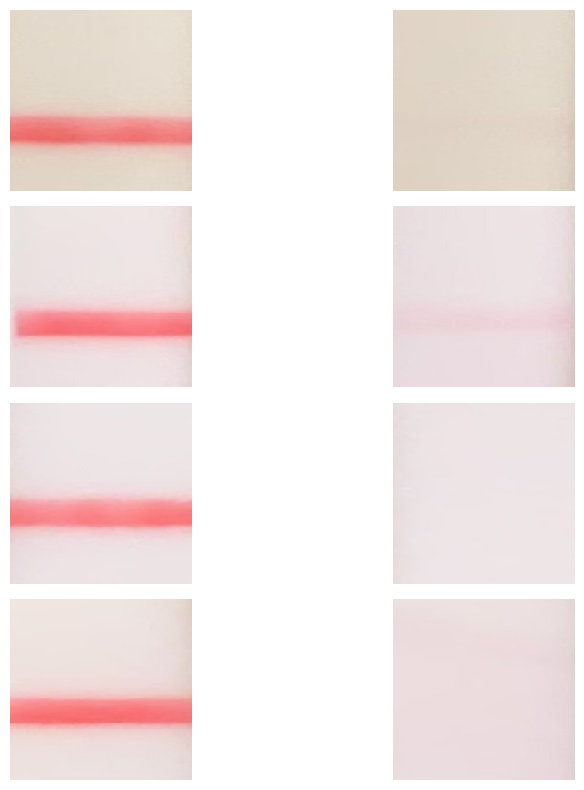

In [18]:
zones, labels = next(iter(loader_train))
print(labels.shape)
print(zones.shape)
show_zones(zones)

## Transformations

In [19]:
from src.data.transformations import PreprocessMembraneZones, AugmentedMembraneZones

In [20]:
kit_id = 'aconag'
transformation = AugmentedMembraneZones()
dataloader = init_dataloader(data_args, kit_id=kit_id, data_mode='train', transform=transformation, 
                             n_workers=0, n_batches=8, shuffle=True)

There are 205 membranes (410 zones) in the aconag kit for train data mode


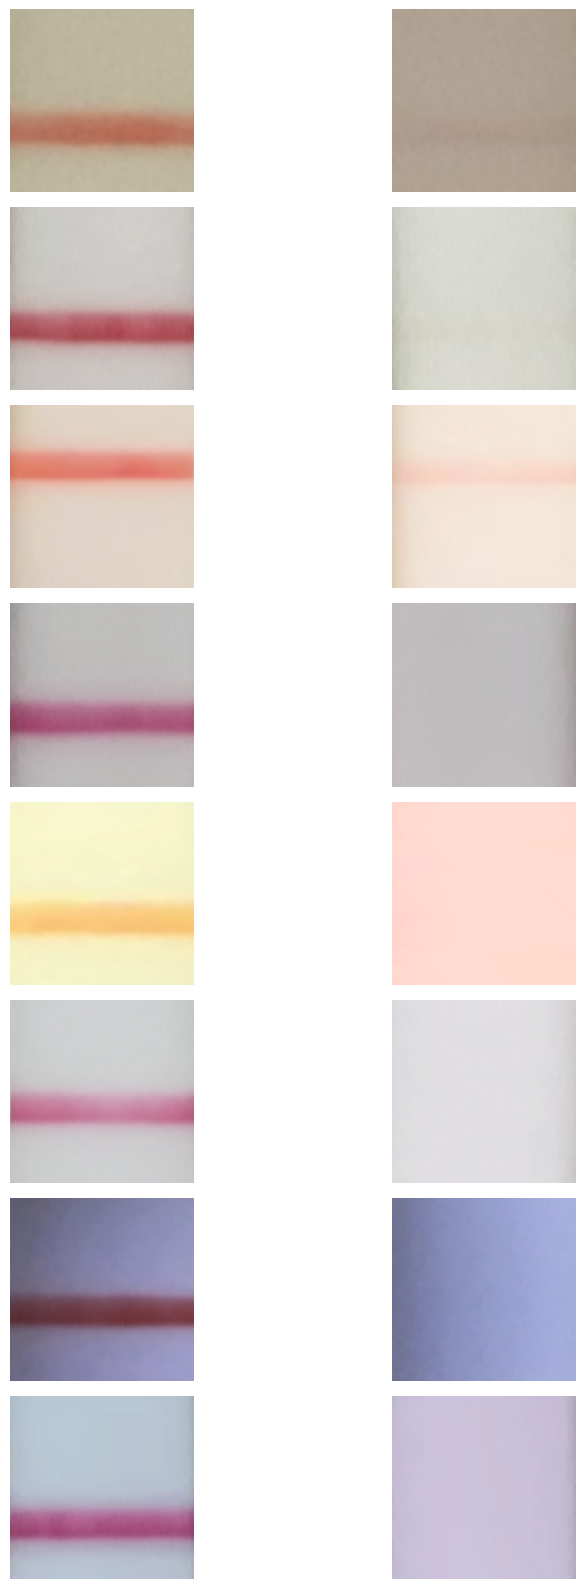

In [24]:
zones, labels = next(iter(dataloader))
show_zones(zones, mean=transformation.mean, std=transformation.std)